### library 설치(colab 기준)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy
!pip install kiwipiepy
!pip install rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.15.0-py3-none-any.whl size=30602629 sha256=b486aa03d6b4d41256d6cfe5f8728a7e8fc56c40ebcecea54688a191ffa7e2ea
  Stored in directory: /root/.cache/pip/wheels/f3/55/41/ca474338ece1bc4314b01445f64ff002d71e19df45575a16e2
Successfully built kiwipiepy-model


In [ ]:
cd "/content/drive/MyDrive/KT/code"

/content/drive/MyDrive/KT/code


## model 불러오기

In [ ]:
from bm25 import BM25
import numpy as np

In [ ]:
bm25 = BM25(articles_path = '/content/drive/MyDrive/KT/data/articles/',
            tokenize_excluding_pos = ["JKS", "JKC", "JKG", "JKO", "JKB", "JKV", "JKQ", "JX", "JC", "EC", "EF"], ## 잘 조절하면 성능 올라감
            tokenize_min_len = 2)

In [ ]:
bm25 = BM25(articles_path = '/content/drive/MyDrive/KT/data/articles/',
             update_data = False)

In [ ]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

with open("/content/drive/MyDrive/KT/data/augmented/final.json") as f:
    data = json.load(f)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
## index -> title dict 생성

index_title_dict = {}
for key, value in tqdm(data.items()):
    index_title_dict[data[key]['index']] = key + "_" + data[key]['title']

def index_to_title(index):
    return(index_title_dict[index])

100%|██████████| 462/462 [00:00<00:00, 453597.48it/s]


In [ ]:
## hit rate 계산

K = 20
count = 0
rank_list = []

for key, value in tqdm(data.items()):
    # 각 key(article)에 대해, score 계산하고,
    # index의 순위를 저장, K 이내에 있는지 살펴보기

    index = data[key]['index']
    questions = data[key]['questions']

    for q in questions:
        score = bm25.get_score(q)
        rank = score.argsort()[::-1].argsort()[index] + 1 ## index의 순위
        rank_list.append(rank)
        if rank <= K:
            count += 1

print()
print(count / (462*5))

## HR@20 : 0.31

100%|██████████| 462/462 [00:04<00:00, 92.64it/s] 


0.31601731601731603


In [ ]:
## 전체 통계량
pd.Series(rank_list).describe()

## 전체의 약 25%는 상위 10개 내에 기존 정답이 존재

count    2310.000000
mean      140.260606
std       144.010296
min         1.000000
25%        10.000000
50%        83.000000
75%       254.750000
max       461.000000
dtype: float64

[]

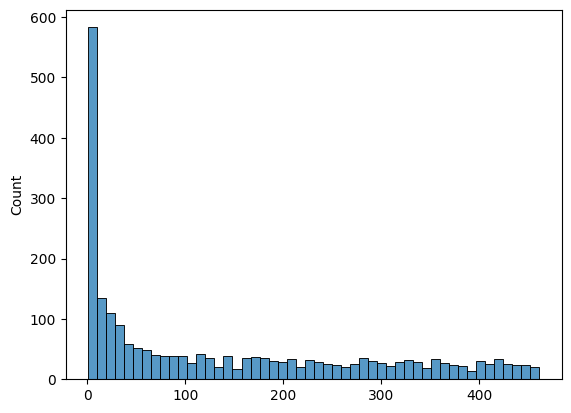

In [ ]:
## 상위 30개 정도 내에 정답 존재하는 비율 꽤 높긴 하나, 뒤로 갈수록 점점 줄어드는 추세는 아님
## 지금 프로젝트는 약 10개 정도 내에 정답이 존재하는 게 바람직한 상황
## 다만 article -> query를 gpt 생성한 것이기에, query-상위 매칭된 article의 관계는 다시 살펴봐야 함

sns.histplot(rank_list, bins = 50)
plt.plot()

In [ ]:
## k 값에 따른 HR 변화

result = sorted(rank_list)
result.reverse()
cum_rank = []

for i in range(1, 463):
    if (i in result):
        cum_rank.append((len(rank_list) - result.index(i))/len(rank_list))
    else:
        cum_rank.append((cum_rank[-1]))

[]

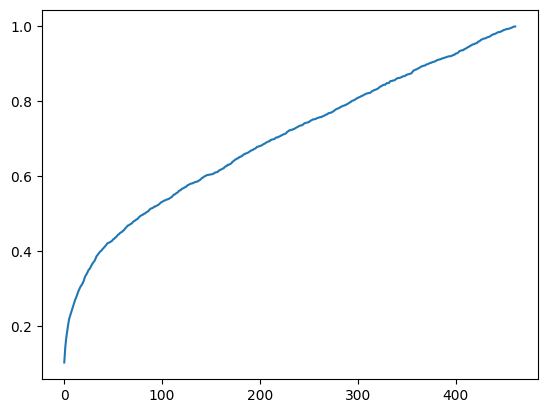

In [ ]:
## K = 50 정도까지 가파르게 증가하다가, 이후 완만해지는 추세를 보임.
## k = 50일 때 약 0.4의 HR를 갖는 듯. (40%의 query는 상위 50개의 article 내에 기존 정답 article이 존재)

sns.lineplot(cum_rank)
plt.plot()

### document similarity 고려

In [ ]:
tag = list(np.load("/content/drive/MyDrive/KT/data/doc_doc.npy"))
notag = list(np.load("/content/drive/MyDrive/KT/data/doc_doc_notag.npy"))

In [ ]:
from sklearn.metrics import ndcg_score

# sklearn.metrics.ndcg_score(y_true, y_score, *, k=None, sample_weight=None, ignore_ties=False)
# y_true: 실제 document sorted 순서
# y_score: predict document 순서

ndcg_score(tag[0], score, k = 20)

In [ ]:
## document similarity 고려해서 ndcg 계산해볼 예정
## 전제: 생성한 query->article 조합이 적절하고, document similarity가 제대로 계산됨